In [ ]:
#Un-comment only when required
#import nltk
#nltk.download('gutenberg')

In [1]:
#Implementing the Skip-Gram Model
from tensorflow.keras.preprocessing import text
from nltk.corpus import gutenberg
from string import punctuation
from tensorflow.keras.preprocessing.sequence import skipgrams

/home/david/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

In [3]:
#Preprocessing Part O
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [4]:
#Preprocessing Part I
bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

In [5]:
bible

[['[', 'The', 'King', 'James', 'Bible', ']'], ['The', 'Old', 'Testament', 'of', 'the', 'King', 'James', 'Bible'], ...]

In [6]:
#Preprocessing Part II
norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

In [7]:
norm_bible

['king james bible',
 'old testament king james bible',
 'first book moses called genesis',
 'beginning god created heaven earth',
 'earth without form void darkness upon face deep',
 'spirit god moved upon face waters',
 'god said let light light',
 'god saw light good god divided light darkness',
 'god called light day darkness called night',
 'evening morning first day',
 'god said let firmament midst waters let divide waters waters',
 'god made firmament divided waters firmament waters firmament',
 'god called firmament heaven',
 'evening morning second day',
 'god said let waters heaven gathered together unto one place let dry land appear',
 'god called dry land earth gathering together waters called seas god saw good',
 'god said let earth bring forth grass herb yielding seed fruit tree yielding fruit kind whose seed upon earth',
 'earth brought forth grass herb yielding seed kind tree yielding fruit whose seed kind god saw good',
 'evening morning third day',
 'god said let ligh

In [8]:
print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


In [9]:
#1-Build the corpus vocabulary
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

In [10]:
word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

In [11]:
vocab_size = len(word2id) + 1 
embed_size = 100

In [12]:
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


In [14]:
#2-Build a skip-gram [(target, context), relevancy] generator
# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

In [16]:
# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(bible (5766), reuben (773)) -> 0
(bible (5766), james (1154)) -> 1
(james (1154), uzziah (1773)) -> 0
(bible (5766), king (13)) -> 1
(bible (5766), standest (4276)) -> 0
(king (13), james (1154)) -> 1
(king (13), dalmatia (12226)) -> 0
(james (1154), bible (5766)) -> 1
(james (1154), jether (3805)) -> 0
(james (1154), king (13)) -> 1


In [17]:
#3-Build the skip-gram model architecture
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dot, Input, Dense, Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential, Model

In [18]:
#The functional API Version
#Receive 1 Integer between 1 and embed_size
word_input = Input(shape=(1,))

# This embedding layer will encode the input sequence
# into a sequence of dense vocab_size-dimensional vectors.
x_word = Embedding(vocab_size, embed_size,embeddings_initializer="glorot_uniform",input_length=1)(word_input)
x_word = Reshape((embed_size, ))(x_word)

context_input = Input(shape=(1,))
x_context = Embedding(vocab_size, embed_size,embeddings_initializer="glorot_uniform",input_length=1)(context_input)
x_context = Reshape((embed_size, ))(x_context)

x = Dot(axes=-1,normalize=True)([x_word, x_context])
x = Dense(1,kernel_initializer="glorot_uniform", activation="sigmoid")(x)

In [19]:
#Defining The model
model = Model(inputs=[word_input,context_input], outputs=[x])

In [20]:
#Model Compiling
model.compile(loss="mean_squared_error", optimizer="rmsprop")

In [21]:
# view model summary
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1242500     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1242500     input_2[0][0]                    
__________________________________________________________________________________________________
reshape (R

In [22]:
# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.manifold import TSNE

Using TensorFlow backend.


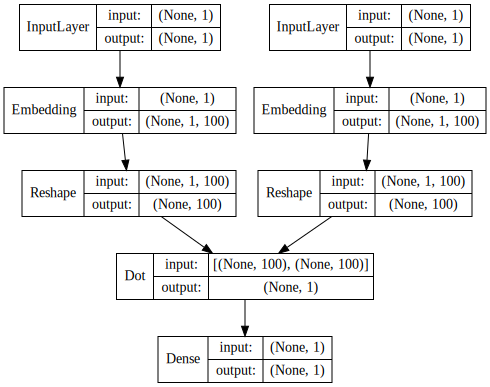

In [23]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [24]:
#4-Training The Model 
for epoch in range(1, 2):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs


/home/david/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Processed 10000 (skip_first, skip_second, relevance) pairs


KeyboardInterrupt: 

In [ ]:
#5-Get Word Embeddings
#merge_layer = model.layers[2]
#word_model = merge_layer.layers[0]
#word_embed_layer = word_model.layers[0]
weights = model.layers[2].get_weights()[0][1:]
print(weights.shape)

In [ ]:
pd.DataFrame(weights, index=id2word.values()).head()

In [ ]:
#Verifying Closeness
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

In [ ]:
words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')